In [1]:
import os,csv,re,sys
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score
sys.path.insert(0, "/share/appspace_data/shared_groups/BGI/USERS/lichuanxiu/KDD/MMSRL-main")
from MMSRL.utils import *
from MMSRL.process import *
from MMSRL import train_model
from datetime import datetime
import argparse

Loading MMSRL package...


In [2]:
section_id="151509"
k=7

In [3]:
adata = sc.read_h5ad(os.path.join('/share/appspace_data/shared_groups/BGI/USERS/lichuanxiu/KDD/MMSRL-main/Data/DLPFC/',
                                  section_id, "DLPFC_" + section_id + '.h5ad'))

In [4]:
adata

AnnData object with n_obs × n_vars = 4789 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'im_re', 'spatial'

In [5]:
adata.var_names_make_unique()
prefilter_genes(adata, min_cells=3)  # avoiding all genes are zeros
# prefilter_specialgenes(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
adata =  adata[:, adata.var['highly_variable']]

In [6]:

lables_df = pd.read_csv(os.path.join('/share/appspace_data/shared_groups/BGI/USERS/lichuanxiu/KDD/MMSRL-main/Data/DLPFC/',
                                  section_id, "cluster_labels_" + section_id + '.csv'), sep=',', header=0, index_col=0)
adata.obs['ground_truth'] = lables_df.loc[adata.obs_names, 'ground_truth']
lables_df = lables_df.replace(1, "Layer 1")
lables_df = lables_df.replace(2, "Layer 2")
lables_df = lables_df.replace(3, "Layer 3")
lables_df = lables_df.replace(4, "Layer 4")
lables_df = lables_df.replace(5, "Layer 5")
lables_df = lables_df.replace(6, "Layer 6")
lables_df = lables_df.replace(7, "WM")
adata.obs['Ground Truth'] = lables_df.loc[adata.obs_names, 'ground_truth']


In [7]:
adata

AnnData object with n_obs × n_vars = 4789 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'ground_truth', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'im_re', 'spatial'

In [8]:
adata.obsm["adj"] = calculate_adj_matrix(adata)
adata= train_model.train(adata,k,h=[3000,3000],n_epochs=200,enhancement=False,radius=0)

[2025-12-28 22:37:40] Epoch: 0/200, Loss: 12.9997
[2025-12-28 22:37:47] Epoch: 5/200, Loss: 10.9351
[2025-12-28 22:37:54] Epoch: 10/200, Loss: 9.3330
[2025-12-28 22:38:01] Epoch: 15/200, Loss: 6.6923
[2025-12-28 22:38:08] Epoch: 20/200, Loss: 5.9414
[2025-12-28 22:38:15] Epoch: 25/200, Loss: 5.6046
[2025-12-28 22:38:22] Epoch: 30/200, Loss: 5.4744
[2025-12-28 22:38:29] Epoch: 35/200, Loss: 5.3836
[2025-12-28 22:38:35] Epoch: 40/200, Loss: 5.3251
[2025-12-28 22:38:42] Epoch: 45/200, Loss: 5.2823
[2025-12-28 22:38:49] Epoch: 50/200, Loss: 5.2507
[2025-12-28 22:38:56] Epoch: 55/200, Loss: 5.2245
[2025-12-28 22:39:03] Epoch: 60/200, Loss: 5.2045
[2025-12-28 22:39:10] Epoch: 65/200, Loss: 5.1816
[2025-12-28 22:39:16] Epoch: 70/200, Loss: 5.1621
[2025-12-28 22:39:23] Epoch: 75/200, Loss: 5.1398
[2025-12-28 22:39:30] Epoch: 80/200, Loss: 5.1145
[2025-12-28 22:39:37] Epoch: 85/200, Loss: 5.0821
[2025-12-28 22:39:44] Epoch: 90/200, Loss: 5.0514
[2025-12-28 22:39:50] Epoch: 95/200, Loss: 5.0273


In [9]:
obs_df = adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['MMSRL'], obs_df['Ground Truth'])
print('Adjusted rand index = %.2f' % ARI)

Adjusted rand index = 0.77


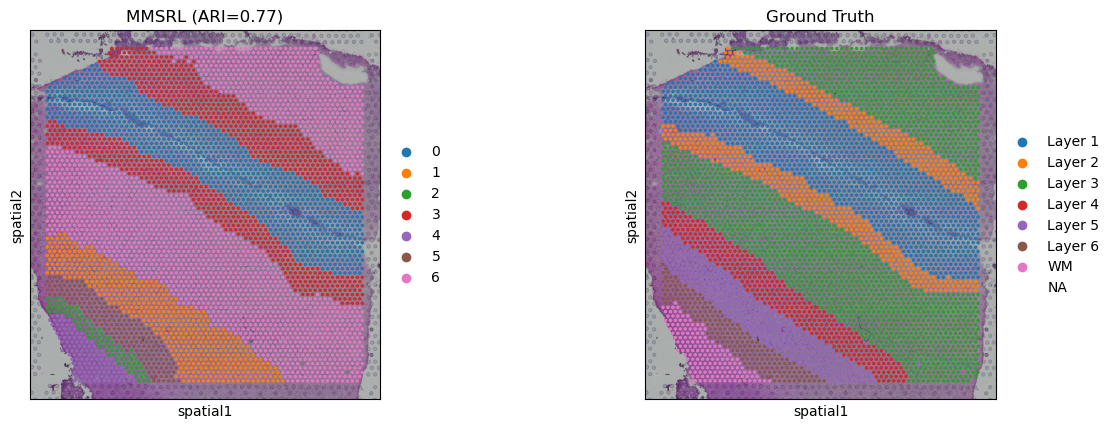

In [10]:
sc.pl.spatial(adata, color=["MMSRL", "Ground Truth"], title=['MMSRL (ARI=%.2f)' % ARI, "Ground Truth"],
           save=section_id)
